In [1]:
from IPython.display import display, Image, Audio
import cv2
import base64
import time
from openai import OpenAI
import os
import requests
import os

client = OpenAI()

In [2]:
video = cv2.VideoCapture("maholo_eefR_Move2Tube.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

500 frames read.


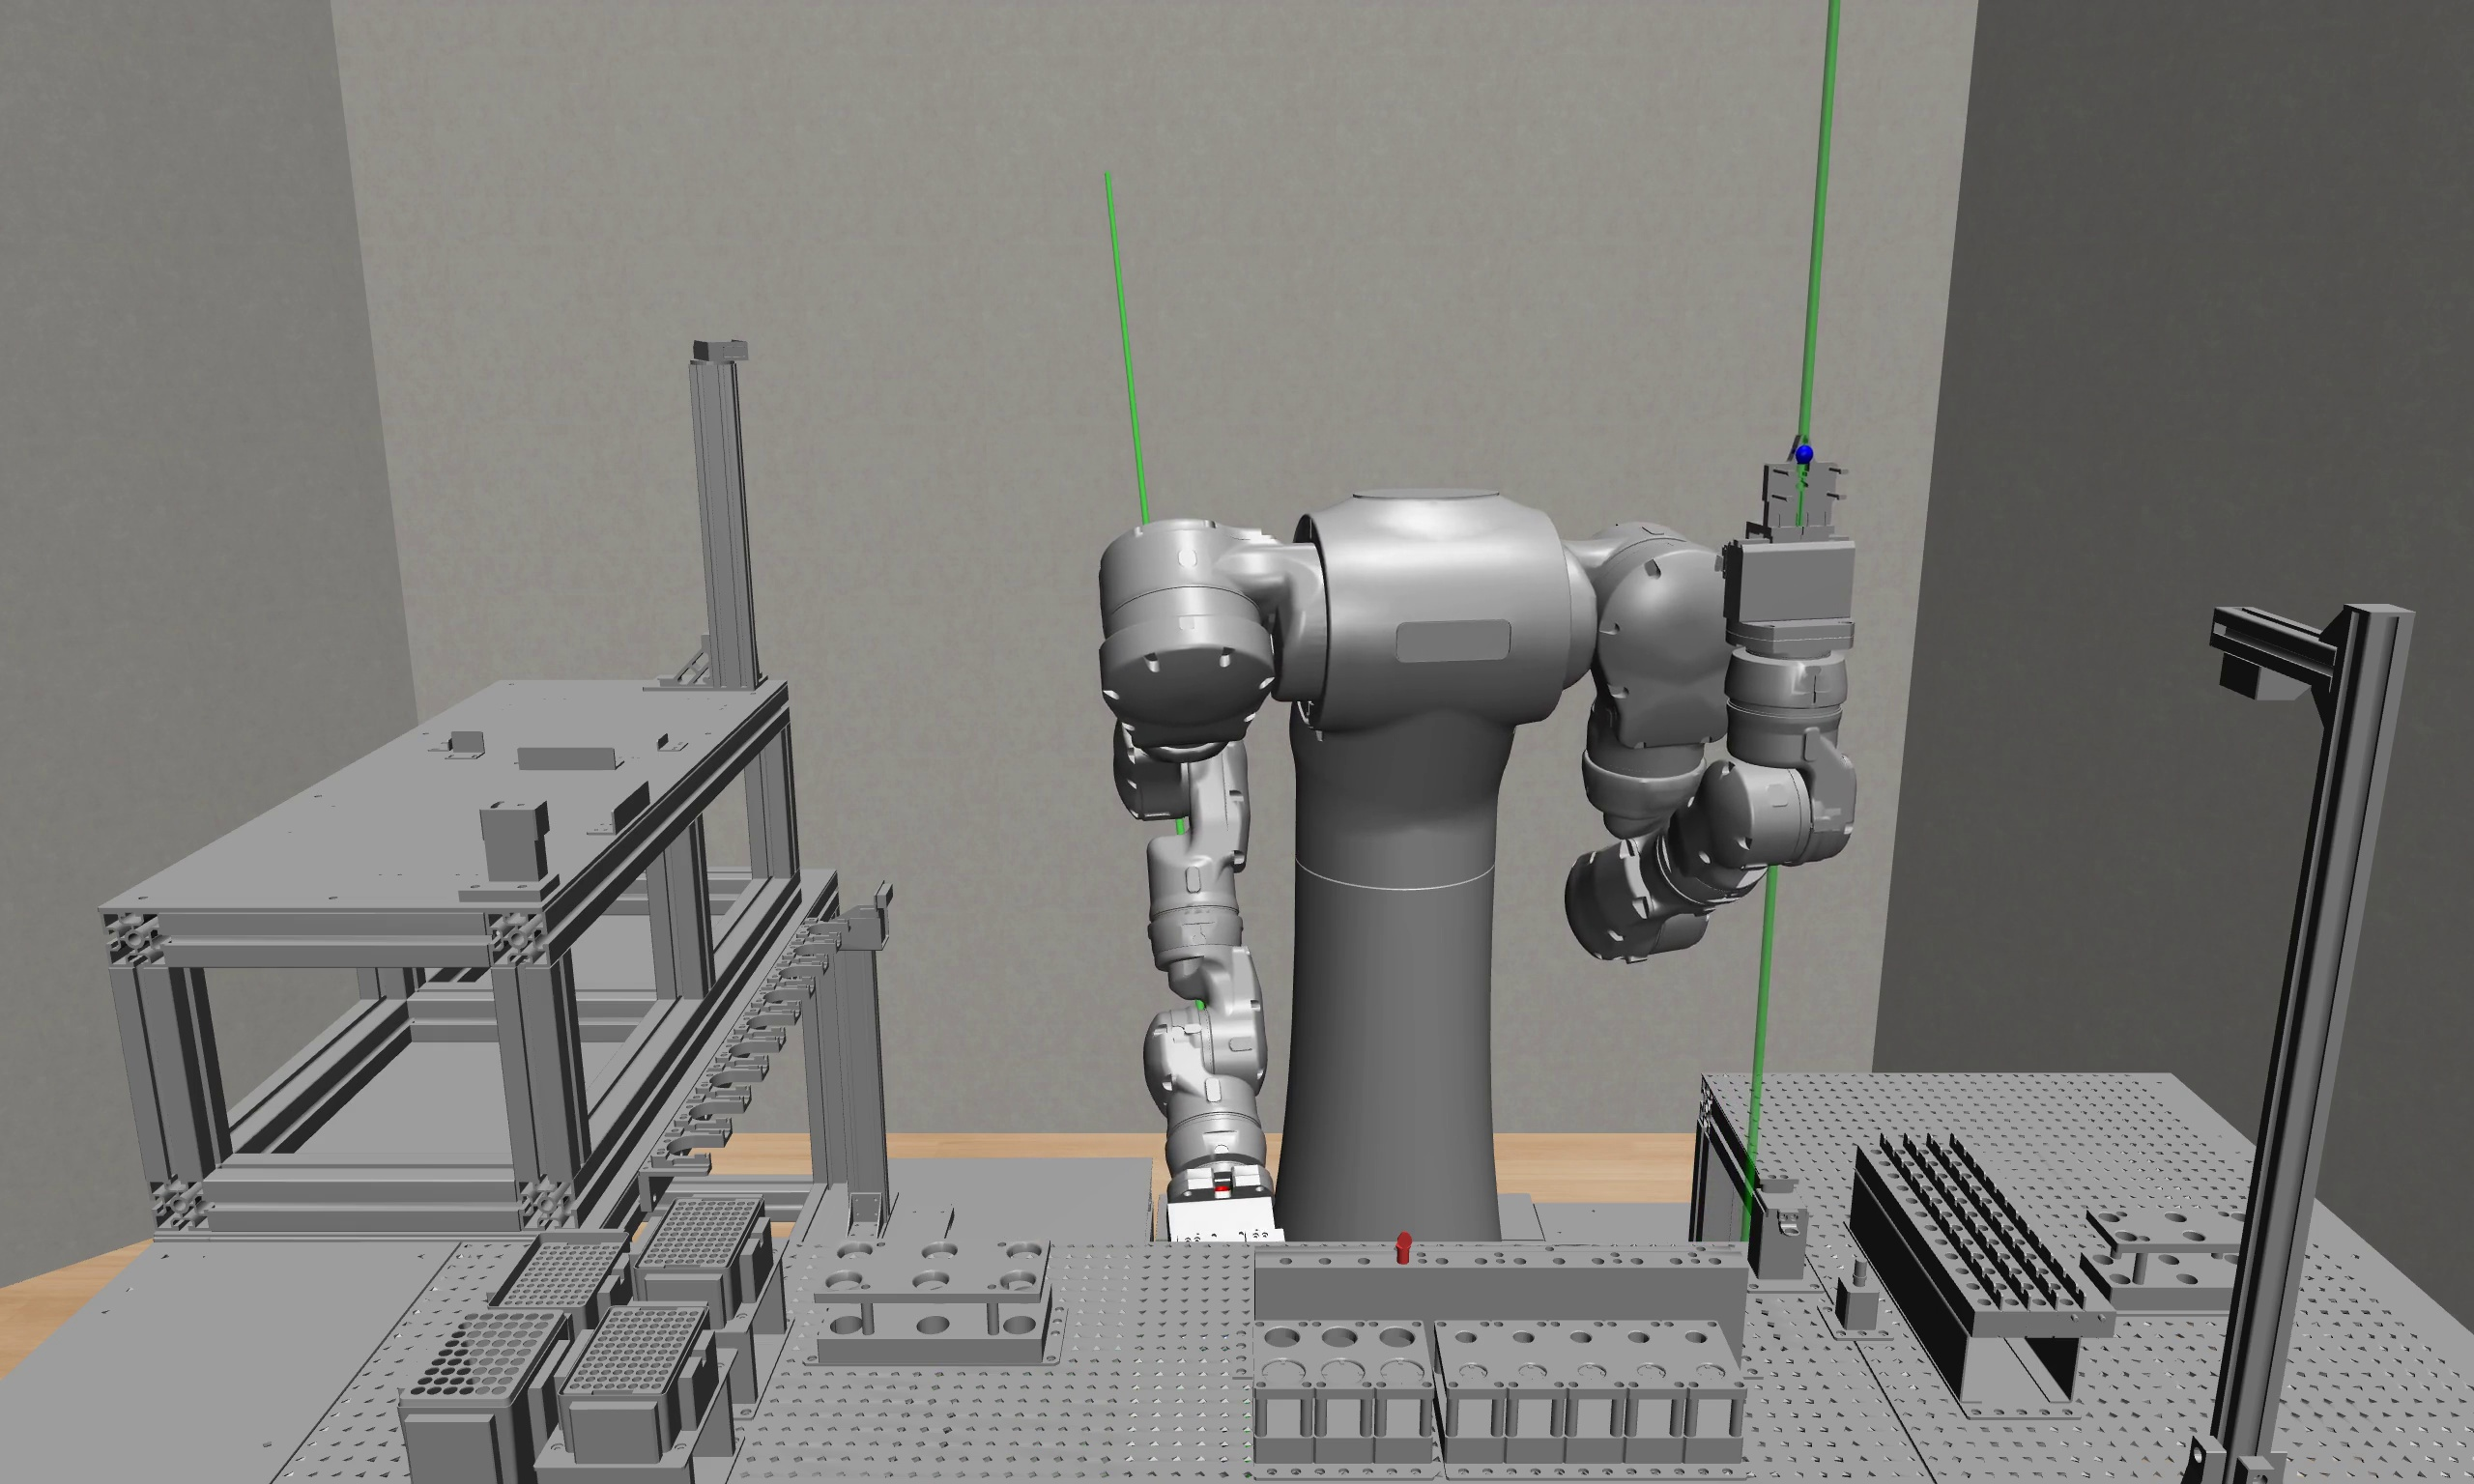

In [3]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.0001)

In [6]:
prompt = """
    请解析一段机器人运动任务的连续时间的图片。我的目的是使用并用强化学习训练机器人使其可以将夹住蓝色的pipette并移动到红色的tube的正上方。
    但是从目前的学习结果来看并不能很好的完成任务。请通过我目前的reward函数以及视频结果，分析失败的原因并给出reward函数修改的提案。
    我的机器人是一个15轴机器人，分成躯干1轴，左右臂各7轴。另外左右夹具各1轴。
    1. 请根据图片分析机器人要完成的任务。
    2. 机器人环境是基于mujoco和robosuite建立的，环境的观测值目前定义如下，请帮我看一下是否有需要修改？
        Key: robot0_joint_pos_cos, Value.shape: (15,)
        Key: robot0_joint_pos_sin, Value.shape: (15,)
        Key: robot0_joint_vel, Value.shape: (15,)
        Key: robot0_right_eef_pos, Value.shape: (3,)
        Key: robot0_right_eef_quat, Value.shape: (4,)
        Key: robot0_right_gripper_qpos, Value.shape: (2,)
        Key: robot0_right_gripper_qvel, Value.shape: (2,)
        Key: robot0_left_eef_pos, Value.shape: (3,)
        Key: robot0_left_eef_quat, Value.shape: (4,)
        Key: robot0_left_gripper_qpos, Value.shape: (2,)
        Key: robot0_left_gripper_qvel, Value.shape: (2,)
        Key: tube008_initial_pos, Value.shape: (3,)
        Key: tube008_pos, Value.shape: (3,)
        Key: tube008_quat, Value.shape: (4,)
        Key: pipette004_initial_pos, Value.shape: (3,)
        Key: pipette004_pos, Value.shape: (3,)
        Key: pipette004_quat, Value.shape: (4,)
        Key: target_pos, Value.shape: (3,)
        Key: target_quat, Value.shape: (4,)
        Key: g1_to_target_pos, Value.shape: (3,)
        Key: g1_to_target_quat, Value.shape: ()
        Key: g0_to_target_pos, Value.shape: (3,)
        Key: g0_to_target_quat, Value.shape: ()
    3. 任务完成的函数目前定义如下：
    def _check_success(self):
        g1 = self.robots[0].gripper["left"]
        check_grasp = self._check_grasp(gripper=g1, object_geoms=self.pipette004)
        check_dist = np.all(np.abs(self._gripper1_to_target_pos)<0.05)
        check_quat =  self._gripper1_to_target_quat<0.1
        check_pipette = np.all(np.abs(self._pipette004_pos_bottom - (self._tube008_pos+np.array([0, 0, 0.05])))<0.05)
        return check_grasp and check_dist and check_quat and check_pipette
    def reward(self, action=None):
        reward = 0
        dist_g1_to_target_pos = np.linalg.norm(self._gripper1_to_target_pos)
        dist_g1_to_target_quat = self._gripper1_to_target_quat
        dist_pipette_over_tube_pos = np.linalg.norm(self._pipette004_pos_bottom - (self._tube008_pos+np.array([0, 0, 0.05])))
        # reward for success
        if self._check_success():
            reward = 2.0
        else:
            # reward/penalty for dist and quat to target
            if self.reward_version == "v0":
                reward += 0.5 - (dist_g1_to_target_pos+dist_pipette_over_tube_pos)/2
                reward += 0.5 - dist_g1_to_target_quat

            elif self.reward_version == "v1":
                if dist_g1_to_target_pos > 0.5:
                    reward += 0.1 * (0.5 - (dist_g1_to_target_pos+dist_pipette_over_tube_pos)/2)
                elif 0.2 < dist_g1_to_target_pos <= 0.5:
                    reward += 0.5 * (0.5 - (dist_g1_to_target_pos+dist_pipette_over_tube_pos)/2)
                elif 0.1 < dist_g1_to_target_pos <= 0.2:
                    reward += 1.0 * (0.5 - (dist_g1_to_target_pos+dist_pipette_over_tube_pos)/2)
                else:
                    reward += 2.0 * (0.5 - (dist_g1_to_target_pos+dist_pipette_over_tube_pos)/2)
                reward += 0.5 - dist_g1_to_target_quat
            # penalty for pipette drop
            g1 = self.robots[0].gripper["left"]
            check_grasp = self._check_grasp(gripper=g1, object_geoms=self.pipette004)
            if not check_grasp: reward -= 1

            # penalty for pipette movement
            current_relavite_dist = np.linalg.norm(self._eef1_xpos - self._pipette004_pos)
            current_relavite_quat = np.array(Quaternion.absolute_distance(Quaternion(self._eef1_xquat), Quaternion(self._pipette004_quat)))
            # print(self._gripper1_to_target_pos, self._pipette004_pos_bottom - (self._tube008_pos+np.array([0, 0, 0.05])), self._gripper1_to_target_quat)
            reward -= 100 * np.abs(current_relavite_dist - self.pre_relavite_dist)
            reward -= 100 * np.abs(current_relavite_quat - self.pre_relavite_quat)
            self.pre_relavite_dist = current_relavite_dist
            self.pre_relavite_quat = current_relavite_quat
        # penalty for right arm joint movement
        action_joints = np.linalg.norm(action[1:9])
        if action_joints > 0.0001: reward -= action_joints
        return reward
        强化学习将使用SAC来训练agent。请帮我具体修改reward函数，给出具体的修改代码，尽量使用robosuite已有的函数。
    """
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            prompt,
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 2000,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

1. 从图片中，我们可以看到一个机器人需要执行以下任务：使用它的夹具捉住蓝色的移液管（pipette），并将其精确移动到一个红色管子（tube）的正上方。该任务涉及精准的夹取、移动和定位，这对于机器人控制和强化学习训练都是非常挑战性的任务。

2. 你当前定义的环境观测值包含了机器人关节的位置、速度、末端执行器的位置和姿态，以及管子和移液管的位置和姿态。这些观测值看起来非常详尽。可能需要添加的一个观测值是关于夹具和目标物体的相对距离和方向，以及它们之间的接触力信息，这样可以更好的让机器人学习如何夹取物体。此外，添加一些视觉信息，例如图像或深度图，也可能有助于提高机器人的性能。

3. 关于奖励函数的改进，可以考虑以下几点：

- 对于距离和姿态误差，使用连续且单调递增的惩罚曲线，而不是分段函数。这可以平滑地指导机器人行动，并提供更一致的学习信号。
- 添加一个终端奖励，以便在任务成功时给予额外的正奖励，强化学习正确的夹取和放置。
- 对于夹取不成功的惩罚，可以设置为与成功奖励的相对值，用于平衡成功与失败之间的奖励差异。
- 对于管子和移液管之间的相对位置与姿态，可以引入更复杂的奖励方案，考虑它们之间的相互关系，而不是单独对它们的位置和姿态进行惩罚。

下面是一个改进后的奖励函数的例子，其中使用了连续的惩罚曲线，并通过扩大或缩小各部分的权重来平衡不同部分之间的重要性。请根据你的实际情况调整这些权重和参数。

```python
def reward(self, action=None):
    reward = 0
    # Continuous penalties for various distances and orientations
    dist_g1_to_target_pos = np.linalg.norm(self._gripper1_to_target_pos)
    dist_g1_to_target_quat = self._gripper1_to_target_quat
    dist_pipette_over_tube_pos = np.linalg.norm(self._pipette004_pos_bottom - (self._tube008_pos+np.array([0, 0, 0.05])))
    
    # 